# Data Lab basic functionality
*Robert Nikutta & the NOAO Data Lab Team*

<a class="anchor" id="toc"></a>
# Table of Contents
* [Module imports](#imports)
* [Get help from the helpers module: make a query object](#helpers)
* [DECaLS sky coverage](#decalssky)
 * [Query the database (synchroneously)](#sync)
 * [Plot an all-sky coverage map](#plotallsky)
 * [Compute clusters & outlines](#outlines)
* [Photometry of a field](#photometry)
 * [Get average photometry](#photometry)
 * [Asynchroneous queries](#async)
 * [Magnitude distribution and Hess diagramm](#hess)
* [Extras](#extras)

<a class="anchor" id="imports"></a>
# Module imports
Import some packages for data handling and plotting. Also import datalab code. We'll use the `helpers` module in this notebook, which hides some of the technical boilerplate.

In [1]:
# std lib
from cStringIO import StringIO

# 3rd party
import numpy as N
import pylab as p
import matplotlib
%matplotlib inline

# Datalab
from dl import authClient, queryClient, helpers

<a class="anchor" id="helpers"></a>
## Get help from the helpers module: make a query object
Class `Querist` from the `helpers` module is there to make handling your (simple) queries easier. Feel free to use the `authClient` and `queryClient` modules directly if needed.

An authentication token is obtained by `authClient.login()` and stored as `.token`

In [2]:
Q = helpers.Querist(authClient.login('anonymous'))
print Q.token

anonymous.0.0.anon_access


Equipped with the `Querist` helper, we can try to run some database queries now.

<a class="anchor" id="decalssky"></a>
## DECaLS sky coverage
Let's get a sense of the DECaLS field sky coverage. Select a list of all fields (called 'bricks' in DECaLS) from the `bricks_dr3` table.
<a class="anchor" id="sync"></a>
### Query the database (synchroneously)
We will use the `Querist` instance to get some tables into RAM. Let's see what output formats are currently supported:

In [3]:
Q.output_formats

'outfmt' arg   Returned output
------------------------------
      string   CSV formatted table as a string
       array   Numpy array
 structarray   Numpy structured / record array
      pandas   Pandas dataframe
       table   Astropy Table
     votable   Astropy VOtable


A simple Numpy array sounds good, so we will supply `outfmt='array'` to the Q:

In [4]:
# the query is just a string
query = "SELECT ra,dec,nexp_g AS ng,nexp_r AS nr, nexp_z AS nz FROM ls_dr3.bricks_dr3 WHERE (nexp_g+nexp_r+nexp_z)>0"

# 'preview' sets how many rows should be printed here
result = Q(query,outfmt='array',preview=2)

Returning Numpy array
RESULT PREVIEW (2 rows)
ra,dec,ng,nr,nz
315,-21.75,0,13,0
315.067064083458,-21.5,0,13,0


The result is indeed a Numpy array:

In [5]:
print type(result)
print result.shape
print result[:3,:]

<type 'numpy.ndarray'>
(144783, 5)
[[ 315.          -21.75          0.           13.            0.        ]
 [ 315.06706408  -21.5           0.           13.            0.        ]
 [ 315.26865672  -21.75          0.           13.            0.        ]]


<a class="anchor" id="plotallsky"></a>
### Plot brick positions on all-sky map
Let's convert RA & Dec into radians first, and wrap-around RA at 180 degrees.

In [6]:
# Put RA, Dec & no. of exposures per brick in separate arrays for convenience
ra, dec, nexp = result[:,0], result[:,1], N.sum(result[:,2:],axis=-1)

# uses one of the Data Lab helpers
ra, dec = helpers.normalizeCoordinates(ra,dec)

Now we can plot the all-sky map

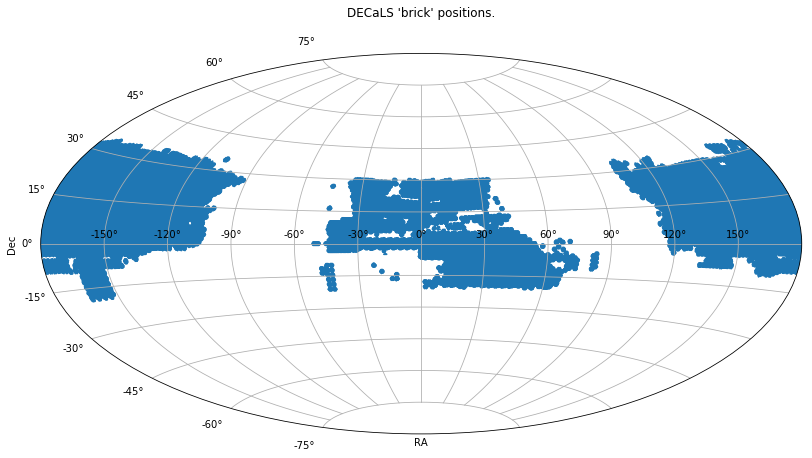

In [7]:
# uses default units 'deg' for ra & dec, converts internally to radian
helpers.plotSkymapScatter(ra,dec,c=None,title="DECaLS 'brick' positions.")

<a class="anchor" id="outlines"></a>
### Compute and plot sky coverage outlines
The outlines of the sky coverage can be computed as a convex hull of all points. However, because the coverage has several disjoint regions, let's automatically find clusters first.

In [8]:
%%time
# uses default method 'MiniBatchKMeans' (a batch version of 'KMeans')
# needs to know how many clusters we're looking for; is fast!
# another method is 'DBSCAN'; needs no prior information, is more accurate, but much slower
clusters = helpers.findClusters(ra,dec,n_clusters=3)
labels = clusters.labels_
print "Unique cluster labels:", N.unique(labels)

Unique cluster labels: [0 1 2]
CPU times: user 604 ms, sys: 131 ms, total: 735 ms
Wall time: 1.81 s


Plot the clusters in different colors

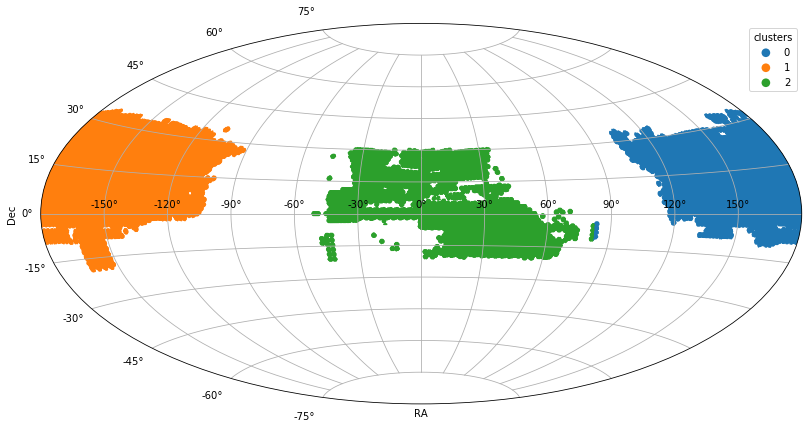

In [9]:
helpers.plotSkymapScatter(ra,dec,clusterlabels=labels,plot='scatter')

Also plot automatically computed cluster outlines

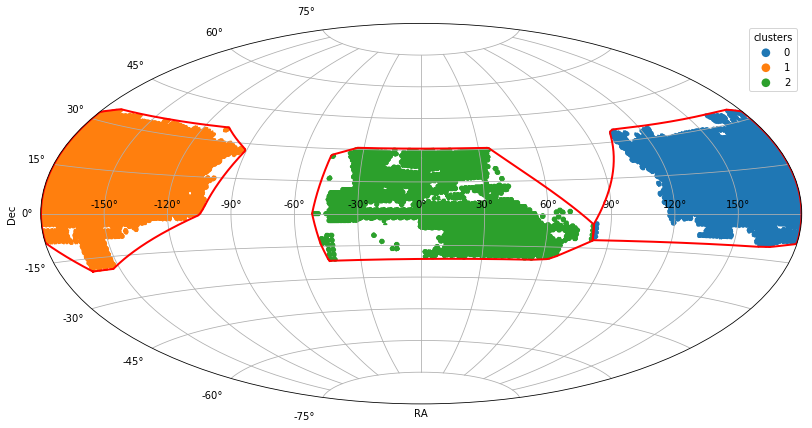

In [10]:
# plot='both' is default if clusterlabels != None
helpers.plotSkymapScatter(ra,dec,clusterlabels=labels,plot='both')

Or plot just the outlines

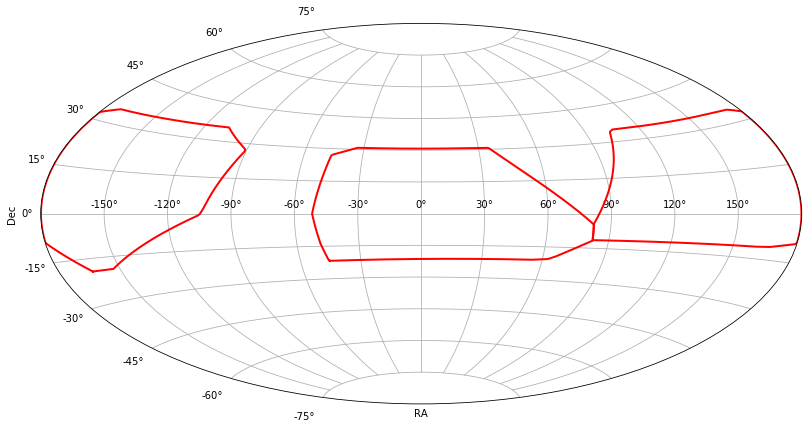

In [11]:
helpers.plotSkymapScatter(ra,dec,clusterlabels=labels,plot='outlines')

### Plot all-sky map of DECaLS field positions

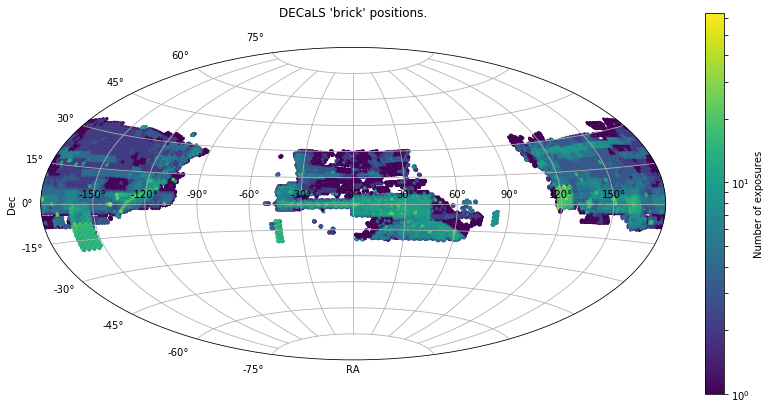

In [12]:
helpers.plotSkymapScatter(ra,dec,c=nexp,title="DECaLS 'brick' positions.",clabel='Number of exposures',norm=matplotlib.colors.LogNorm())

<a class="anchor" id="photometry"></a>
# Average photometry of all objects in one field
We'll select the g & r mags from fields in DECaLS and produce mag distributions and color-magnitude diagrams.

<a class="anchor" id="async"></a>
# Asynchroneous query
A large query could take some time to complete. Then it's a good idea to submit it in async mode, come back later to check its status, and when the status is 'COMPLETED', retrieve the results.

In [13]:
def makequery(ra0,dec0,fov=2.):  # all in degrees
    fov2 = fov/2.
    ralo, rahi = ra0-fov2, ra0+fov2
    declo, dechi = dec0-fov2, dec0+fov2
    # In DECaLS, bands 2 & 3 = g & r; we're selecting mags g & r, and compute signal-to-noise rations for g & r on the fly
    query = """SELECT g, r, decam_flux_2*sqrt(decam_flux_ivar_2) as snr_g, decam_flux_3*sqrt(decam_flux_ivar_3) as snr_r FROM ls_dr3.tractor_primary
               WHERE
                 g != 'nan' AND g != 'inf' AND
                 r != 'nan' AND r != 'inf' AND
                 ra BETWEEN %g AND %g AND
                 dec BETWEEN %g AND %g""" % (ralo,rahi,declo,dechi)
    return query

Generate query string, and submit the query in async mode:

In [14]:
q1 = makequery(242,8)
field1 = Q(q1,outfmt='structarray',preview=2,async=True)

Asynchronous query submitted as jobid=f5r9pa4c9p5qa6hw
Get results a bit later with: result = Q()


Let's see what async jobs are in the queue

In [15]:
Q.openjobs

deque([('f5r9pa4c9p5qa6hw', 'structarray', 2)])

Every async query submitted via `Q` is a tuple (`jobid`,`outfmt`,`preview`), where `jobid` is a unique job identifier string, and the rest is what's needed to retrieve the result.

Multiple jobs can be submitted asynchroneously, `Querist` will keep track of them in a FIFO queue (first-in-first-out):

In [16]:
# a different field; and a different outfmt for fun
field2 = Q(makequery(0.,0.),outfmt='pandas',preview=2,async=True)

Asynchronous query submitted as jobid=e1lt2lpl72oqx8nw
Get results a bit later with: result = Q()


And check the queue again...

In [17]:
Q.openjobs

deque([('f5r9pa4c9p5qa6hw', 'structarray', 2),
       ('e1lt2lpl72oqx8nw', 'pandas', 2)])

It now shows two asynchroneously submitted queries, waiting for completion.

Let's try to retrieve the result of the first query (field1). If its status is not yet COMPLETED, it will be *automatically* re-inserted into the queue, at its old position; no *queue jumping* ;-)

In [18]:
field1 = Q() # no arguments = get the first async job in the queue

jobid, outfmt, preview f5r9pa4c9p5qa6hw structarray 2
Async query job f5r9pa4c9p5qa6hw is COMPLETED. Attempting to retrieve results.
Returning Numpy structured / record array
RESULT PREVIEW (2 rows)
g,r,snr_g,snr_r
22.297174,21.388155,43.751050030486788,47.725968258067603
26.189589,24.130827,1.2177637774679491,3.2443616321515356


Check the async job queue again...

In [19]:
Q.openjobs

deque([('e1lt2lpl72oqx8nw', 'pandas', 2)])

Looks like the `field1` query result has been retrieved, and the job removed from the queue. Let's check it out:

In [20]:
print type(field1)
print field1.dtype.names
print field1['g'][:5]

<type 'numpy.ndarray'>
('g', 'r', 'snr_g', 'snr_r')
[ 22.297174  26.189589  23.661142  22.600121  25.417128]


Now let's retrieve the results requested in the 2nd async query

In [21]:
field2 = Q()

jobid, outfmt, preview e1lt2lpl72oqx8nw pandas 2
Async query job e1lt2lpl72oqx8nw is COMPLETED. Attempting to retrieve results.
Returning Pandas dataframe
RESULT PREVIEW (2 rows)
g,r,snr_g,snr_r
25.230408,24.436705,3.8505477601532694,6.6294923266029393
26.416374,24.423555,1.2876804723813484,6.6995190396918263


How does this one look?

In [22]:
print type(field2)
print field2['g'][:3]

<class 'pandas.core.frame.DataFrame'>
0    25.230408
1    26.416374
2    24.637480
Name: g, dtype: float64


<a class="anchor" id="hess"></a>
# Plot histograms and a color-magnitude diagram
Let's plot the g magnitude distribution and the color-magnitude diagrams of both DECaLS fields. We define a little plotting function for convenience.

In [23]:
def plotpanel(fig,axspec,x,y=None,xlabel='',ylabel=''):
    ax = fig.add_subplot(axspec)
    if y is None:
        ax.hist(x,bins=30,histtype='step',color='b',label='g',lw=2,alpha=0.6)
        ax.set_yscale('log')
        ax.set_ylabel('number of sources / bin')
        ax.set_title('nobj=%d' % x.size)
    else:
        im = ax.hexbin(x,y,gridsize=200,norm=matplotlib.colors.LogNorm())
        cb = p.colorbar(im,aspect=40,pad=0.01)
        cb.set_label('number of sources per 2D bin')
        ax.set_xlim(-2,3)
        ax.set_ylim(25,10)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

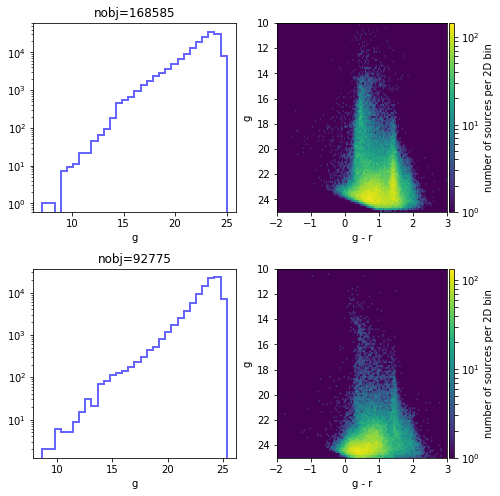

In [24]:
ok1 = (field1['snr_g'] > 5) & (field1['snr_r'] > 5) # selections
ok2 = (field2['snr_g'] > 5) & (field2['snr_r'] > 5)

fig = p.figure(figsize=(8,8))
plotpanel(fig,221,field1['g'][ok1],xlabel='g')
plotpanel(fig,222,(field1['g']-field1['r'])[ok1],field1['g'][ok1],xlabel='g - r',ylabel='g')
plotpanel(fig,223,field2['g'][ok2],xlabel='g')
plotpanel(fig,224,(field2['g']-field2['r'])[ok2],field2['g'][ok2],xlabel='g - r',ylabel='g')
fig.subplots_adjust(hspace=0.3)

# Clear the async queue (e.g. if you're just playing around)
Say you populated the async queue with jobs, but you are no longer interested in them. Or you need a clean queue to start fresh.

In [25]:
res1 = Q(makequery(0,0),async=True)
res2 = Q(makequery(20,30),async=True)
Q.openjobs

Asynchronous query submitted as jobid=e9lmwcybosba798c
Get results a bit later with: result = Q()
Asynchronous query submitted as jobid=y9yo2bny7vz0ymk1
Get results a bit later with: result = Q()


deque([('e9lmwcybosba798c', 'array', 0), ('y9yo2bny7vz0ymk1', 'array', 0)])

You can clear the queue like this

In [26]:
Q.clearQueue()
Q.openjobs

Clearing the queue of async queries.


deque([])

<a class="anchor" id="Extras"></a>
# Extras

# Low-level methods
Helpers can make life easier. But when a helper is not available (write one yourself!), or the circumstances require it, you can always use the lower-level Data Lab functions directly. Here a few examples.

# Log-in and obtain an authentication token

In [39]:
from dl import authClient
token = authClient.login('anonymous','') # use your actual: username, password
print token

anonymous.0.0.anon_access


# Run a (sync) query

In [28]:
from dl import queryClient
query = 'SELECT ra,dec,gmag FROM smash_dr1.object WHERE gmag BETWEEN 9 AND 25 LIMIT 5'
response = queryClient.query(token,query,fmt='csv')
print response
print type(response)

ra,dec,gmag
103.06835492271753,-37.973538878907263,22.141075
103.07177411628449,-37.97359942947962,21.493074
103.07159782799786,-37.972329108796394,22.169075
103.05233746119532,-37.970829734223685,19.639074
103.05572178353961,-37.969888312040695,18.752075

<type 'str'>


# Manually convert the result to a data structure

## To Numpy array

In [29]:
from cStringIO import StringIO
query = 'SELECT ra,dec,gmag FROM smash_dr1.object WHERE gmag BETWEEN 9 AND 25 LIMIT 5'
response = queryClient.query(token,query,fmt='csv')
ar = N.loadtxt(StringIO(response),skiprows=1,delimiter=',')
print ar.shape

(5, 3)


## To Pandas data frame

In [30]:
import pandas as pd
df = pd.read_csv(StringIO(response))
print df

           ra        dec       gmag
0  103.068355 -37.973539  22.141075
1  103.071774 -37.973599  21.493074
2  103.071598 -37.972329  22.169075
3  103.052337 -37.970830  19.639074
4  103.055722 -37.969888  18.752075


# Automatically save the query result to a file on your vospace

In [31]:
query = 'SELECT ra,dec,gmag FROM smash_dr1.object WHERE gmag BETWEEN 9 AND 25 LIMIT 5'
response = queryClient.query(token,query,fmt='csv',out='vos://foo.csv')

# List the contents of your vospace

In [32]:
from dl import storeClient
storeClient.ls(token,'vos://')

'usno_b14_foo.csv,usno_b14.csv,tmp,public,foo.csv,f169_200.csv,f169_100.csv'

# Get an URL to download a file from vospace

In [33]:
storeClient.get(token,'vos://foo.csv','foo.csv')

url.text = http://dldb1.sdm.noao.edu:8080/vospace-2.0/vospace/data/95ced670-07ff-4bb8-84ae-d4dcb6827840


# Delete a file from vospace

In [34]:
print "Before:", storeClient.ls(token,'vos://')
storeClient.rm(token,'vos://foo.csv')
print "After:", storeClient.ls(token,'vos://')

Before: usno_b14_foo.csv,usno_b14.csv,tmp,public,foo.csv,f169_200.csv,f169_100.csv
After: usno_b14_foo.csv,usno_b14.csv,tmp,public,f169_200.csv,f169_100.csv


# Store the query result to mydb

In [35]:
query = 'SELECT ra,dec,gmag FROM smash_dr1.object WHERE gmag BETWEEN 9 AND 25 LIMIT 5'
response = queryClient.query(token,query,out='mydb://table2')

# List tables in your mydb

In [36]:
print queryClient.list(token)

http://dlsvcs.datalab.noao.edu/query/list?table=
t2
table2



# Delete (drop) a table in mydb

In [37]:
print "Before:", queryClient.list(token)
queryClient.drop(token,'table2')
print "After:", queryClient.list(token)

Before: http://dlsvcs.datalab.noao.edu/query/list?table=
t2
table2

After: http://dlsvcs.datalab.noao.edu/query/list?table=
t2



# Load data from a table in mydb

to be written...